In [2]:
import sys
print("SYS",sys.version)
import numpy as np
import keras
import tensorflow as tf
print(tf.__version__)

# tf.set_random_seed(42)
import keras.backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Embedding
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from keras.utils import np_utils
# from tf.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle

SYS 3.10.2 (main, Mar 16 2022, 10:43:30) [GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]
2.10.0


In [14]:
# This is the training data
training_file ="train.tsv"



corpus = ""
for line in open(training_file).readlines():

	# Each line in the training data is two columns
	# тыкгаткэта ивнин риӄукэтэ	ты>кгат>кэ>та ив>ни>н риӄукэ>тэ
	row = line.strip().split('\t')
	# print("row", row)
	# The tokens are in the first column
	tokens = row[0]
	# Add the tokens to the list of sentences
	corpus+=tokens


print(set(corpus))
chars = sorted(list(set(corpus)))
print(chars)
char_index = dict((c,i) for i,c in enumerate(chars))
index_char = dict((i,c) for i,c in enumerate(chars))
char_index["<UNK>"]=len(chars)
index_char[len(chars)]="<UNK>"
print(char_index)
print(index_char)

SEQUENCE_LENGTH = 10
step = 1
sentences = []
next_chars = []
X=[]
Y=[]
for i in range(0, len(corpus) - SEQUENCE_LENGTH, step):
    sentences = corpus[i: i + SEQUENCE_LENGTH]
    next_chars = corpus[i + SEQUENCE_LENGTH]
    X.append([char_index[char] for char in sentences])
    Y.append(char_index[next_chars])
    
n_patterns = len(X)
print("Y length:",len(Y))
print("Patterns: ",n_patterns)
vocab_size = len(chars) + 1
x = np.reshape(X, (n_patterns, SEQUENCE_LENGTH, 1))
y = np_utils.to_categorical(Y,num_classes=vocab_size)

print(x)
print(y)
print("Total vocab size: ",vocab_size)


{'с', ' ', 'з', 'к', 'а', 'н', 'ч', 'ъ', 'д', 'г', 'қ', 'р', 'й', 'в', 'я', 'ʼ', 'о', 'б', 'ц', 'х', 'ь', 'и', 'п', 'ӈ', 'ж', 'ы', 'ф', 'ю', 'е', 'ё', '’', 'ӄ', 'у', 'э', 'щ', 'ң', 'м', 'ш', 'ԓ', 'т'}
[' ', 'ʼ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'қ', 'ң', 'ӄ', 'ӈ', 'ԓ', '’']
{' ': 0, 'ʼ': 1, 'а': 2, 'б': 3, 'в': 4, 'г': 5, 'д': 6, 'е': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'м': 13, 'н': 14, 'о': 15, 'п': 16, 'р': 17, 'с': 18, 'т': 19, 'у': 20, 'ф': 21, 'х': 22, 'ц': 23, 'ч': 24, 'ш': 25, 'щ': 26, 'ъ': 27, 'ы': 28, 'ь': 29, 'э': 30, 'ю': 31, 'я': 32, 'ё': 33, 'қ': 34, 'ң': 35, 'ӄ': 36, 'ӈ': 37, 'ԓ': 38, '’': 39, '<UNK>': 40}
{0: ' ', 1: 'ʼ', 2: 'а', 3: 'б', 4: 'в', 5: 'г', 6: 'д', 7: 'е', 8: 'ж', 9: 'з', 10: 'и', 11: 'й', 12: 'к', 13: 'м', 14: 'н', 15: 'о', 16: 'п', 17: 'р', 18: 'с', 19: 'т', 20: 'у', 21: 'ф', 22: 'х', 23: 'ц', 24: 'ч', 25: 'ш', 26: 'щ', 

In [15]:
print(y.shape)

(1118341, 41)


In [16]:
print(len(chars))

40


In [17]:
print("Shape of X:",x.shape)
print("Shape of Y:",y.shape)

Shape of X: (1118341, 10, 1)
Shape of Y: (1118341, 41)


In [18]:
print(X[1:10])

[[13, 2, 17, 2, 4, 12, 30, 4, 2, 17], [2, 17, 2, 4, 12, 30, 4, 2, 17, 2], [17, 2, 4, 12, 30, 4, 2, 17, 2, 19], [2, 4, 12, 30, 4, 2, 17, 2, 19, 30], [4, 12, 30, 4, 2, 17, 2, 19, 30, 14], [12, 30, 4, 2, 17, 2, 19, 30, 14, 0], [30, 4, 2, 17, 2, 19, 30, 14, 0, 19], [4, 2, 17, 2, 19, 30, 14, 0, 19, 2], [2, 17, 2, 19, 30, 14, 0, 19, 2, 2]]


In [19]:
embedding_dim = 10


In [20]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length = SEQUENCE_LENGTH))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

# optimizer = RMSprop(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 10)            410       
                                                                 
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 41)                5289      
                                                                 
 activation_1 (Activation)   (None, 41)                0         
                                                                 
Total params: 76,867
Trainable params: 76,867
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.optimizer.lr=0.0001
history = model.fit(x, y, validation_split=0.05, batch_size=128, epochs=70, shuffle=True).history

Epoch 1/70
8301/8301 [==============================] - 219s 26ms/step - loss: 2.7719 - accuracy: 0.1855 - val_loss: 2.4780 - val_accuracy: 0.2441
Epoch 2/70
8301/8301 [==============================] - 219s 26ms/step - loss: 2.4728 - accuracy: 0.2432 - val_loss: 2.3627 - val_accuracy: 0.2597
Epoch 3/70
8301/8301 [==============================] - 220s 27ms/step - loss: 2.3945 - accuracy: 0.2581 - val_loss: 2.2861 - val_accuracy: 0.2771
Epoch 4/70
8301/8301 [==============================] - 225s 27ms/step - loss: 2.3384 - accuracy: 0.2726 - val_loss: 2.2219 - val_accuracy: 0.2970
Epoch 5/70
8301/8301 [==============================] - 217s 26ms/step - loss: 2.2925 - accuracy: 0.2875 - val_loss: 2.1687 - val_accuracy: 0.3171
Epoch 6/70
8301/8301 [==============================] - 218s 26ms/step - loss: 2.2553 - accuracy: 0.3004 - val_loss: 2.1212 - val_accuracy: 0.3380
Epoch 7/70
8301/8301 [==============================] - 217s 26ms/step - loss: 2.2224 - accuracy: 0.3132 - val_loss: 2

In [22]:
import matplotlib.pyplot as plt

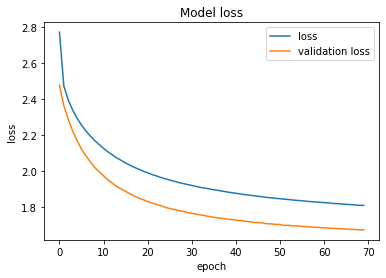

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','validation loss'])
#plt.savefig("100epochs_lr1e-1_seq40_embedding.png")

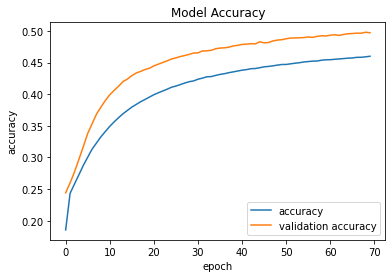

In [24]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','validation accuracy'])
#plt.savefig("100epochs_lr1e-1_accuracy_seq40_embedding.png")

In [25]:
model_file = "LSTM_embeddinglayer_dropout50_epochs70_final.dat"
mf = open(model_file, 'wb')
pickle.dump(model, mf)

INFO:tensorflow:Assets written to: ram://5f94e628-453f-44cb-9f42-a666ae051bad/assets


INFO:tensorflow:Assets written to: ram://5f94e628-453f-44cb-9f42-a666ae051bad/assets
